# Coins similarity model

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data
from IPython.display import clear_output
from scipy.ndimage.interpolation import rotate

%run ../common/datasets.ipynb
%run ../common/visualisation.ipynb

%matplotlib inline

COIN_DATASET_PATH = "/netforge/datasets/private/roman/coins/images"

# Data

In [2]:
class CoinsData:
    def __init__(self, image_shape):
        self.image_shape  = image_shape
        self.train_images = []
        self.test_images  = []
        
    def load(self, path, data_size):
        self.path = path
        res = load_image_dataset(self.image_shape, path, data_size)
        (
            image_shape, 
            file_num,
            self.train_images, 
            train_labels, 
            self.test_images, 
            test_labels
        ) = res
        return res
    
    def get_next_batch(self, bs, augment=None):
        data = self.train_images
        idx  = np.random.choice(np.arange(len(data)), bs)
        img1 = np.copy(data[idx])

        per = np.arange(bs)
        per = np.roll(per, shift=1+np.random.randint(bs-1))

        img1 = np.reshape(img1, [-1,]+self.image_shape)
        img2 = img1[per]
        true = np.zeros([bs,2])
        same = np.random.randint(2, size=bs)

        augment = augment or (lambda im: im)
        
        for i in range(bs):
            true[i,same[i]] = 1.
            if same[i]:
                img2[i] = augment(img1[i])
                img1[i] = augment(img1[i])
            else:
                img1[i] = augment(img1[i])
                img2[i] = augment(img2[i])

        return img1, img2, true

## Test data

File num   : 200
Data size  : 100
Train shape: [100, 16384]
Test  shape: [100, 16384]
Image shape: [128, 128, 1]

Train images:


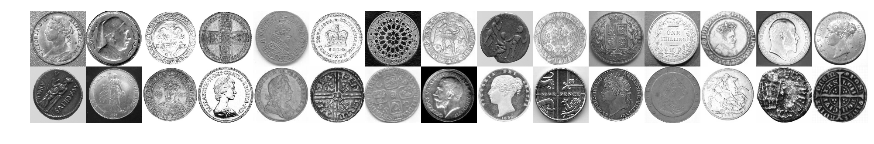

Test images:


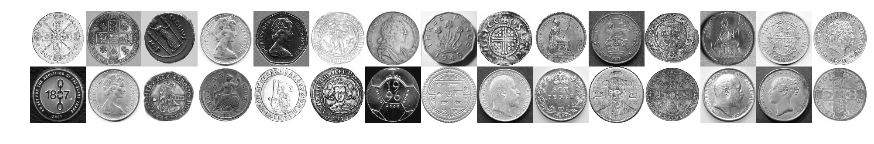

In [3]:
def test_data(data_size):
    data = CoinsData(image_shape=[128, 128, 1])
    (
        image_shape, 
        file_num,
        train_images, 
        train_labels, 
        test_images, 
        test_labels
    ) = data.load(COIN_DATASET_PATH, data_size)

    print("File num   :", file_num)
    print("Data size  :", data_size)
    print("Train shape:", list(train_images.shape))
    print("Test  shape:", list(test_images.shape))
    print("Image shape:", image_shape)
    print()
    print("Train images:")
    show_images(train_images, image_shape, rows=2, cols=15)
    print("Test images:")
    show_images(test_images, image_shape, rows=2, cols=15)
test_data(100)

# Augmentation

In [4]:
class CoinAugmentator:
    _params = {
        'smooth'    : .8,
        'angle'     : 90,
        'brightness': .25,
        'contrast'  : [.5, 1.5],
    }
    
    def __init__(self, cache_size=42):
        self._cache      = dict()
        self._cache_size = cache_size
        
    def augment(self, im, use_cache=True, rate=1):
        shape = im.shape
        w = shape[1]
        h = shape[0]
        if use_cache:
            hc = hash(im.tostring())
            cached = self._cache.get(hc, [])
            if len(cached) >= self._cache_size:
                return np.copy(cached[np.random.randint(self._cache_size)])

        im = np.copy(im)

        # smooth
        p = self._params['smooth']
        k = p*np.random.random(1)**2 * rate
        if k > 0.1:
            kernel = np.ones([5,5],np.float32)/25
            old= np.copy(im)
            im = cv2.filter2D(im,-1,kernel)
            im = np.reshape(im, shape)
            im = k*im + (1-k)*old

        # angle
        p = self._params['angle']
        k = np.random.uniform(-p, p) * rate
        c = np.mean(im[:10,:10])
        im[0,:]   = c
        im[h-1,:] = c
        im[:,0]   = c
        im[:,w-1] = c
        im = rotate(im, k, reshape=False, mode='nearest')

        # brightness
        p = self._params['brightness']
        k = np.random.uniform(1-p, 1+p) * rate
        im = im * k
        im = np.minimum(im,1)
        im = np.maximum(im,0)

        # contrast
        p = self._params['contrast']
        k = rate*np.random.uniform(*p) + (1-rate)
        im = np.power(im, k)

        # bounding
        assert np.all(im<=1)
        assert np.all(im>=0)

        # cache
        if use_cache:
            cached.append(im)
            self._cache[hc] = cached
        return im    

## Test augmentation

Original:


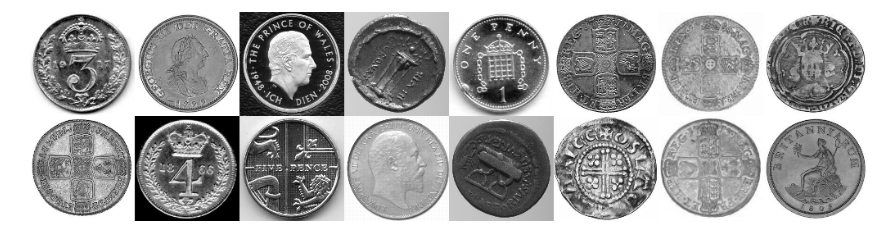

Augmented:


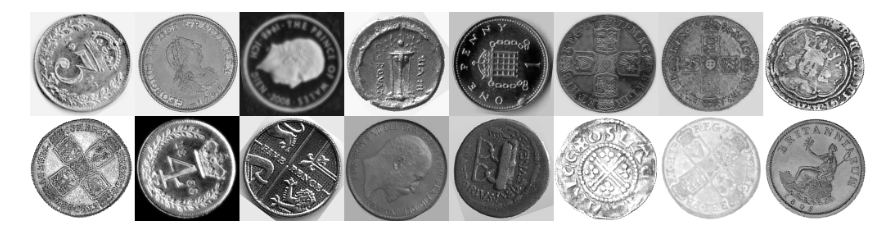

In [5]:
def test_augmentation():
    data_size = 100
    data = CoinsData(image_shape=[128, 128, 1])
    data.load(COIN_DATASET_PATH, data_size)
    aug = CoinAugmentator()

    train_images = data.train_images
    image_shape  = data.image_shape
    augment      = aug.augment

    n = 16
    s = np.random.randint(data_size-n)
    im1 = np.reshape(train_images[s:s+n], [-1,] + image_shape)
    im2 = np.copy(im1)
    for i in range(n):
        im2[i] = augment(im2[i], use_cache=False, rate=1)
    print("Original:")
    show_images(im1, image_shape[:2], cols=n//2, rows=2)
    print("Augmented:")
    show_images(im2, image_shape[:2], cols=n//2, rows=2)
    
test_augmentation()

## Test batching

data_size: 100
path     : /netforge/datasets/private/roman/coins/images
use_aug  : False
['       0', '       0', '       0', '       1', '       0', '       1', '       0', '       0']


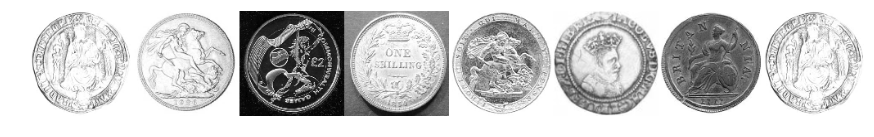

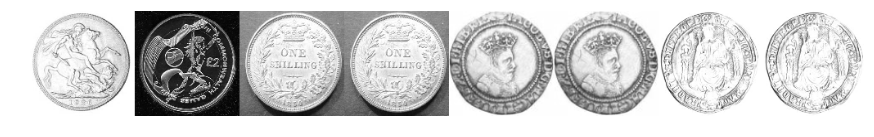

data_size: 100
path     : /netforge/datasets/private/roman/coins/images
use_aug  : True
['       1', '       1', '       1', '       1', '       0', '       0', '       0', '       0']


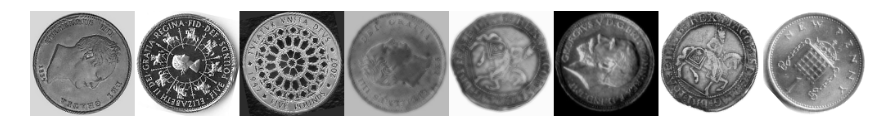

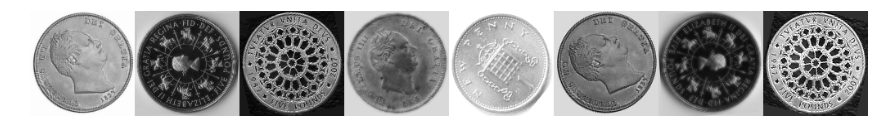

In [6]:
def test_batching(data_size, use_aug):
    data = CoinsData(image_shape=[128, 128, 1])
    data.load(COIN_DATASET_PATH, data_size)
    aug = CoinAugmentator()

    train_images   = data.train_images
    image_shape    = data.image_shape
    get_next_batch = data.get_next_batch
    augment        = aug.augment if use_aug else None
    
    n = 8
    im1, im2, t = get_next_batch(n, augment)
    
    print("data_size:", data_size)
    print("path     :", data.path)
    print("use_aug  :", use_aug)
    print(["%8d"%t[i][1] for i in range(len(im1))])
    show_images(im1, image_shape[:2], cols=n, rows=1)
    show_images(im2, image_shape[:2], cols=n, rows=1)
    
test_batching(100, use_aug = False)
test_batching(100, use_aug = True)

# Model

In [9]:
class CoinSimiratityModel:
    
    def __init__(self, image_shape):
        self.data    = CoinsData(image_shape)
        self.aug     = CoinAugmentator()
        self.session = None
        self.graph   = None

    def _similarity_nn(self, image1, image2):
        def conv2d_maxpool(inputs, filters, kernel_size=[3,3], padding="same", activation=tf.nn.relu):
            l = tf.layers.conv2d(
                inputs=inputs,
                filters=filters,
                kernel_size=kernel_size,
                padding=padding,
                activation=tf.nn.relu)
            return tf.layers.max_pooling2d(l, pool_size=[2, 2], strides=2)
        
        l = tf.concat([image1, image2], axis=1)
        l = conv2d_maxpool(l, 16)
        l = conv2d_maxpool(l, 32)
        l = conv2d_maxpool(l, 64)
        l = conv2d_maxpool(l, 128)
        l = tf.contrib.layers.flatten(l)
        l = tf.layers.dense(l, units=500, activation=tf.nn.relu)
        l = tf.layers.dense(l, units=2)
        logits     = l
        similarity = tf.nn.softmax(logits)
        return {'logits':logits, 'similarity':similarity}

    def load_data(self, data_path, data_size):
        self.data.load(data_path, data_size)
        self._is_loaded = True

    def build(self):
        tf.reset_default_graph()
        self.graph = tf.Graph()
        image_shape = self.data.image_shape
        with self.graph.as_default(), tf.name_scope('similarity'), tf.device('/gpu:0'):
            # placeholders
            self.image1_pl = tf.placeholder(dtype=tf.float32, shape=[None,]+image_shape, name='image1')
            self.image2_pl = tf.placeholder(dtype=tf.float32, shape=[None,]+image_shape, name='image2')
            self.true_pl   = tf.placeholder(dtype=tf.float32, shape=[None, 2], name='true')
            self.lr_pl     = tf.placeholder(dtype=tf.float32, name='lr')
            # network
            self.network   = self._similarity_nn(self.image1_pl, self.image2_pl)
            # operations
            self.logits_op = self.network['logits']
            self.sim_op    = self.network['similarity']
            self.loss_op   = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=self.true_pl, logits=self.logits_op))
            self.train_op  = tf.train.AdamOptimizer(self.lr_pl).minimize(self.loss_op)
            self.init_op   = tf.global_variables_initializer()
        self._is_built = True

    def train(self, step_num, batch_size, learning_rate = 1e-4, log_every=1, loss_mean_window = 30):
        assert self._is_loaded, "Model data is not loaded"
        assert self._is_built,  "Model is not built"
        
        if self.session:
            self.session.close()
        
        self.session = tf.Session(graph=self.graph)
        self.session.run(self.init_op)
            
        try:
            losses   = []
            for step in range(step_num):
                img1, img2, true = self.data.get_next_batch(batch_size)
                _, loss = self.session.run([self.train_op, self.loss_op], feed_dict={
                    self.image1_pl: img1,
                    self.image2_pl: img2,
                    self.true_pl  : true,
                    self.lr_pl    : learning_rate
                })
                losses.append(loss)
                if step % log_every == log_every-1:
                    show_losses(losses, step, step_num, loss_mean_window)
                if np.mean(losses[-loss_mean_window:]) < .1:
                    break
        except KeyboardInterrupt:
            pass
        show_losses(losses, step, step_num, loss_mean_window)


## Test model

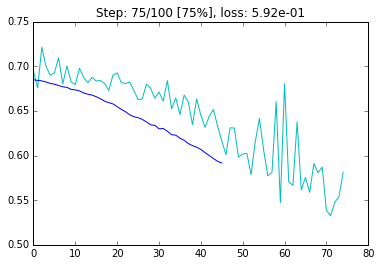

In [ ]:
def test_train_model(step_num, data_size, batch_size):
    model = CoinSimiratityModel(image_shape=[128,128,1])
    model.load_data(COIN_DATASET_PATH, data_size)
    model.build()
    model.train(step_num, batch_size)
    
test_train_model(step_num=100, data_size=200, batch_size = 100)

In [ ]:

  # ============================================================================
    # Eval similarity
    def get_similarity(img1, img2, use_aug):
        img1 = np.copy(np.reshape(img1, [-1,]+image_shape))
        img2 = np.copy(np.reshape(img2, [-1,]+image_shape))
        if use_aug:
            for i in range(len(img2)):
                img1[i] = augment(img1[i], use_cache = False)
                img2[i] = augment(img2[i], use_cache = False)
        sim = sess.run(sim_op, feed_dict = {
            image1_pl: img1,
            image2_pl: img2
        })[:,1]
        return img1, img2, sim

    def show_coins_sim(img1, img2, sim, cols=4):
        h  = image_shape[0]
        w  = image_shape[1]
        w3 = 32
        img1 = np.copy(img1.reshape([num*h,w]))
        img2 = np.copy(img2.reshape([num*h,w]))
        img3 = np.ones([num*h, w3])
        for i in range(num):
            s = sim[i]
            assert(0.<=s<=1.)
            img3[i*h:i*h+h] = s
        img1[:,0] = 0
        img3[:,w3-1] = 0
        img3[:,0] = 0
        sheet = np.concatenate([img1, img2, img3], axis=1)
        sheet[np.arange(0,h*num,h)-1,:] = 0
        sheet[np.arange(0,h*num,h)+1,:] = 0
        sheet = np.minimum(sheet, 1)
        print(' '.join(['%.2f'%s for s in sim]))
        print(' '.join(['='*4 if s>.5 else ' '*4 for s in sim]))    
        show_images(images=sheet, image_shape=[h, 2*w+w3], cols=cols, rows=num//cols)

    def test_similarity(images1, images2, num, use_aug=True):
        img1, img2, sim = get_similarity(images1[:num], images2[:num], use_aug)
        show_coins_sim(img1, img2, sim)

    num = 20
    shift = np.random.randint(data_size)
    test_similarity(
        images1  = np.roll(test_images, shift, axis=0), 
        images2  = np.roll(test_images, shift, axis=0), 
        num      = num,
        use_aug  = True)
    test_similarity(
        images1  = np.roll(test_images, shift+1, axis=0), 
        images2  = np.roll(test_images, shift  , axis=0), 
        num      = num,
        use_aug  = False)

    # ============================================================================
    # Eval quality
    def calc_pos_similarity(ds, num, use_aug=True):
        shift = np.random.randint(len(ds))
        img1 = np.roll(ds, shift, axis=0)[:num]
        img2 = np.roll(ds, shift, axis=0)[:num]
        _, _, sim = get_similarity(img1, img2, use_aug)
        return sim


    def calc_neg_similarity(ds, num, use_aug=True):
        shift = np.random.randint(len(ds))
        img1 = np.roll(ds, shift+1, axis=0)[:num]
        img2 = np.roll(ds, shift  , axis=0)[:num]
        _, i_, sim = get_similarity(img1, img2, use_aug)
        return sim

    def show_quality(pos_sim, neg_sim):
        print("Data size          :", len(pos_sim))
        print("Mean positive similarity: %.1f%%" % (np.mean(pos_sim)*100))
        print("Mean negative similarity: %.1f%%" % (np.mean(neg_sim)*100))
        n = 1000
        x = np.zeros(n)
        y = np.zeros(n)
        s = 0
        for i in range(n):
            p = i/n
            x[i] = 1 - np.mean(neg_sim < p)
            y[i] = np.mean(pos_sim > p)
            if i>0:
                s += (y[i]+y[i-1])/2 * (x[i-1]-x[i])
        plt.plot(x, y)
        plt.title("Quality trade-off: %.1f%% (area under curve)" % (s*100))
        plt.xlabel("False negative")
        plt.ylabel("True positive")
        plt.show()


    num = min(500, data_size)
    show_quality(
        pos_sim = calc_pos_similarity(test_images, num, use_aug=True), 
        neg_sim = calc_neg_similarity(test_images, num, use_aug=False))
